In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import os
import sys
import numpy as np
import collections
import scipy.io
import time

# CNN bits
import theano
import theano.tensor as T
import lasagne
from lasagne import layers

# for evaluation
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import evaluation
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# https://groups.google.com/forum/#!topic/lasagne-users/t_rMTLAtpZo
theano.config.profile = True
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn import metrics

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


In [2]:
# load in the data
base_path = '/home/michael/projects/engaged_hackathon_data/urban_8k/'
split = 1
loadpath = base_path + 'splits/split' + str(split) + '.mat'
data = scipy.io.loadmat(loadpath)

num_classes = np.unique(data['train_y']).shape[0]
print "There are %d classes " % num_classes
print np.unique(data['train_y'])
data['train_y'] = data['train_y'].ravel().astype(np.int32)
data['test_y'] = data['test_y'].ravel().astype(np.int32)
data['val_y'] = data['val_y'].ravel().astype(np.int32)

if False:
    for data_type in ['train_', 'test_', 'val_']:
        num = data[data_type + 'X'].shape[0]
        to_use = np.random.choice(num, 100, replace=False)
        data[data_type + 'X'] = data[data_type + 'X'][to_use, :]
        data[data_type + 'y'] = data[data_type + 'y'][to_use]

There are 10 classes 
[0 1 2 3 4 5 6 7 8 9]


In [3]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [4]:
import cPickle as pickle
network, predict_fn = pickle.load(open('./best_model_0.60.pkl'))

In [5]:
# After training, we compute and print the test error:
all_preds = []
all_gt = []
minibatch_size = 8

for batch in iterate_minibatches(data['test_X'], data['test_y'], int(minibatch_size), shuffle=False):
    inputs, targets = batch
    preds = predict_fn(inputs)
    all_preds.append(preds)
    all_gt.append(targets)

all_preds = np.vstack(all_preds)
all_gt = np.hstack(all_gt)

In [6]:
print metrics.accuracy_score(np.argmax(all_preds, axis=1), all_gt)

0.582568807339


In [8]:
import pandas as pd

base_path = '/home/michael/projects/engaged_hackathon_data/urban_8k/'
meta_path = base_path + 'UrbanSound8K/metadata/UrbanSound8K.csv'

unique_labels = [''] * 10

# data = 
data = pd.read_csv(meta_path)
for row in data.iterrows():
    unique_labels[row[1]['classID']] = row[1]['class']
# print data
print unique_labels 

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


/home/michael/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


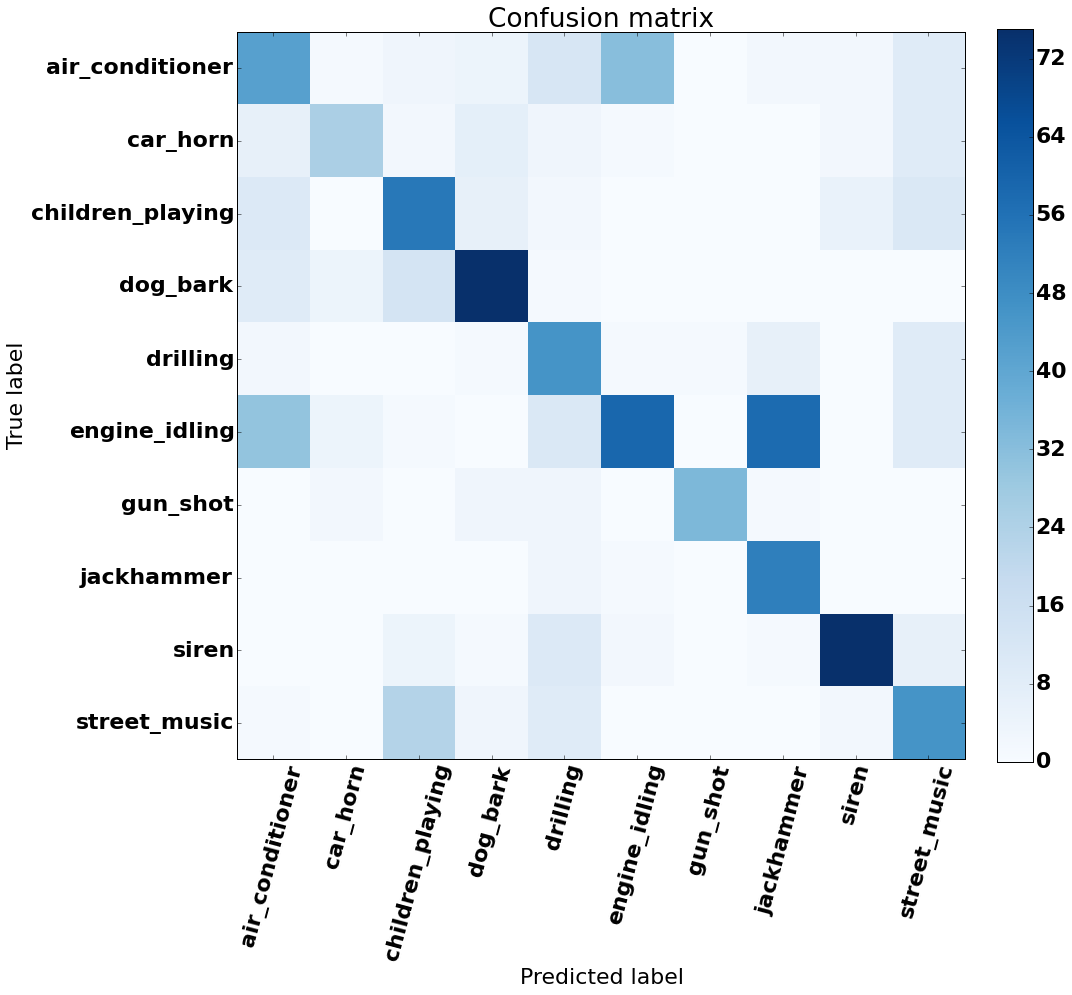

In [9]:
cm = metrics.confusion_matrix(np.argmax(all_preds, axis=1), all_gt)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks, unique_labels, rotation=75)

    plt.yticks(tick_marks, unique_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm)